In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv(f'outputs/output_res_20190610.csv', index_col='timestamp')

In [7]:
df.columns

Index(['price', 'side', 'quantity', 'action', 'bp0', 'bq0', 'bp1', 'bq1',
       'bp2', 'bq2', 'bp3', 'bq3', 'bp4', 'bq4', 'ap0', 'aq0', 'ap1', 'aq1',
       'ap2', 'aq2', 'ap3', 'aq3', 'ap4', 'aq4', 'ofi'],
      dtype='object')

In [25]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook, tqdm
import functools

from helper import SUM, EMA, grid_samples, process_jobs



def calc_order_flow_imbalacne(df, period, verbose=0):
    ofi_sum = SUM(period)
    ofis = []
    indices = range(df.shape[0])
    if verbose == 1:
        indices = tqdm_notebook(indices)
    elif verbose == 2:
        indices = tqdm(indices)
    for i in indices:
        x = df.iloc[i]
        timestamp = df.index[i]
        ofi_sum.update(x['ofi'], timestamp)
        ofi = ofi_sum.get_signal()
        ofis.append(ofi)
    ofis = pd.Series(ofis, index=df.index)
    # insert nan for unstable period
    ofis.loc[:period] = np.nan
    return ofis


def smooth_signals(signals, period, verbose=0):
    ema = EMA(period)
    _smooth_output = []
    indices = range(signals.shape[0])
    if verbose == 1:
        indices = tqdm_notebook(indices)
    elif verbose == 2:
        indices = tqdm(indices)
    for i in indices:
        x = signals.iloc[i]
        if np.isfinite(x):
            timestamp = signals.index[i]
            ema.update(x, timestamp)
            smooth_signal = ema.get_signal()
        else:
            smooth_signal = np.nan
        _smooth_output.append(smooth_signal)
    smooth_output = pd.Series(_smooth_output, index=signals.index)
    # insert nan for unstable period
    smooth_output.loc[:period] = np.nan
    return smooth_output

def calc_smooth_stats(prices, period, verbose=0):
    mean_ema = EMA(period)
    vol_ema = EMA(period)
    vols = []
    mean_prices = []
    indices = range(prices.shape[0])
    if verbose == 1:
        indices = tqdm_notebook(indices)
    elif verbose == 2:
        indices = tqdm(indices)
    for i in indices:
        price = prices.iloc[i]
        if np.isfinite(price):
            timestamp = prices.index[i]
            mean_ema.update(price, timestamp)
            mean_price = mean_ema.get_signal()
            vol_ema.update(abs(price - mean_price), timestamp)
            vol = vol_ema.get_signal()
        else:
            vol = np.nan
            mean_price = np.nan
        vols.append(vol)
        mean_prices.append(mean_price)
    vols = pd.Series(vols, index=prices.index)
    mean_prices = pd.Series(mean_prices, index=prices.index)
    zscores = (prices - mean_prices) / vols
    # insert nan for unstable period
    mean_prices.loc[:period] = np.nan
    vols.loc[:period] = np.nan
    zscores.loc[:period] = np.nan
    return mean_prices, vols, zscores

def calc_micro_price(df, level=1, verbose=0):
    prices = []
    indices = range(df.shape[0])
    if verbose == 1:
        indices = tqdm_notebook(indices)
    elif verbose == 2:
        indices = tqdm(indices)
    for i in indices:
        x = df.iloc[i]
        av = 0
        bv = 0
        ap = x['ap0']
        bp = x['bp0']
        if np.isfinite(ap) and np.isfinite(bp):
            for i in range(level):
                av += x[f'aq{i}']
                bv += x[f'bq{i}']
            price = (ap * bv + bp *av) / (av + bv)
        else:
            price = np.nan
        prices.append(price)
    prices = pd.Series(prices, index=df.index)
    return prices

def calc_return(df, period):
    prices = 0.5 * (df['ap0'] + df['bp0'])
    forward_index = prices.index.searchsorted(prices.index + period)
    forward_index[forward_index == prices.shape[0]] = prices.shape[0] - 1
    ret = prices.values[forward_index] - prices
    ret.loc[prices.index[-1] - period:] = np.nan
    return ret
    
def generate_features(df, period):
    features = dict()
    mid_prices = 0.5 * (df['ap0'] + df['bp0'])
    spread = df['ap0'] - df['bp0']
    volume_imb = df['bq0'] - df['aq0']
    mean_prices, vols, zscores = calc_smooth_stats(mid_prices, period)
    features['vol'] = vols
    features['zscore'] = zscores
    ofi = calc_order_flow_imbalacne(df, period)
    features['ofi'] = ofi
    smooth_volume_imb = smooth_signals(volume_imb, period)
    features['volume_imbalance'] = smooth_volume_imb
    return pd.DataFrame(features)


def calc_features_return_corr(df, feature_period, return_period):
    features = generate_features(df, feature_period)
    returns = calc_return(df, return_period)
    corrs = dict()
    for col in features.columns:
        corr = returns.corr(features[col])
        corrs[col] = corr
    params = {
        'feature_period': feature_period,
        'return_period': return_period,
    }
    return corrs, params


def calc_return_ratio(df, period, th):
    returns = calc_return(df, period)
    returns = returns.dropna()
    returns = returns.loc[~returns.index.duplicated(keep='last')]
    ratio = returns.loc[np.abs(returns) >= th].shape[0] / returns.shape[0]
    return ratio, period

def multi_grid_execution(params_conf, task_func, default_params=None,
                         condition=None, num_threads=None):
    samples = grid_samples(params_conf, condition=condition)
    if default_params is None:
        default_params = dict()
    jobs = []
    for sample in samples:
        sample['func'] = functools.partial(task_func,**default_params)
        jobs.append(sample)
    output = process_jobs(jobs, num_threads=num_threads, task='task')
    return output

In [26]:
periods = np.logspace(6, 9, 10)
ratios = []
for period in periods:
    ratio = calc_return_ratio(df, period, 15)[0]
    ratios.append(ratio)

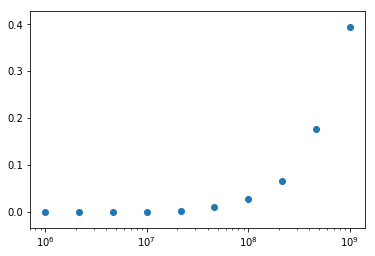

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(periods, ratios)
plt.xscale('log')

In [27]:
period = 1e8
corrs = calc_features_return_corr(df, period, period)

In [28]:
corrs

({'ofi': -0.11912718731728177,
  'vol': -0.019754477124324054,
  'volume_imbalance': 0.048098240223889956,
  'zscore': -0.059657451407377694},
 {'feature_period': 100000000.0, 'return_period': 100000000.0})

In [23]:
returns = calc_return(df, period)

In [25]:
returns.loc[np.abs(returns) >= 10].shape[0] / returns.shape[0]

0.10882266070180746

In [ ]:
return_periods = np.logspace(6, 9, 10)
feature_periods = np.logspace(6, 9, 10)
params_conf = [   
    {'name': 'return_period',  'domain': return_periods},
    {'name': 'feature_period', 'domain': feature_periods},
]

default_params = {
    'df': df,
}

output = multi_grid_execution(params_conf, calc_features_return_corr, default_params)

In [12]:
from collection import defaultdict

scores = defaultdict(lambda: np.zeros((len(return_periods), len(feature_periods))))
for i, return_period in enumerate(return_periods):
    for j, feature_period in enumerate(feature_periods):
        for x in output:
            if x[1]['return_period'] == return_period and x[1]['feature_period'] == feature_period:
                scores[i][j] = x[0]
                for key, val in x[0].items():
                    scores[key][i][j] = val
                break
        

In [14]:
returns = calc_return(df['ap0'], period)

In [18]:
returns.corr(features['ofi'])

-0.09960719847217883

In [88]:
ret = calc_return(mean_prices, 1e8)

In [1]:
periods = np.logspace(6, 9, 10)
def calc_return_ratio(returns, th):
    returns = returns.dropna()
    return returns.loc[np.abs(returns) >= th].shape[0] / returns.shape[0]

In [76]:
period = 1e8 # 100 seconds
mid_prices = 0.5 * (df['ap0'] + df['bp0'])
mean_prices, vols, zscores = calc_vol(mid_prices, period, 1)
# mean_prices = smooth_signals(mid_prices, period)

HBox(children=(IntProgress(value=0, max=138813), HTML(value='')))

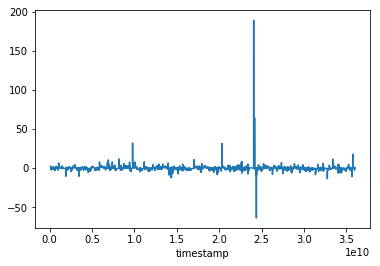

In [77]:
zscores.plot()

In [79]:
micro_prices = calc_micro_price(df, verbose=1)

HBox(children=(IntProgress(value=0, max=138813), HTML(value='')))

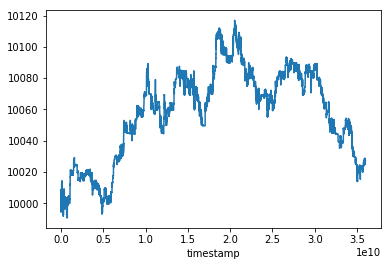

In [80]:
micro_prices.plot()

In [81]:
diffs = micro_prices - mid_prices

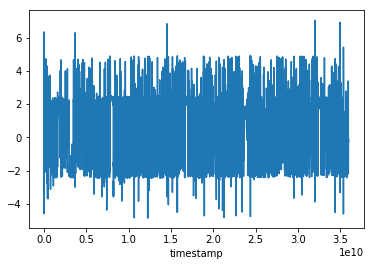

In [82]:
diffs.plot()

In [12]:
ofis = calc_order_flow_imbalacne(df, period)

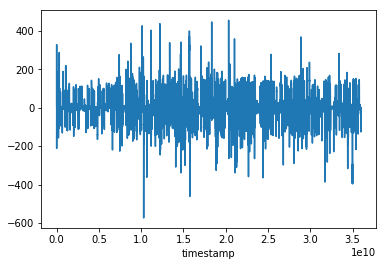

In [14]:
%matplotlib inline
ofis.plot()

In [22]:
ofis.describe()

count    138813.000000
mean         13.437545
std          98.448380
min        -574.000000
25%         -24.000000
50%           0.000000
75%          54.000000
max         456.000000
dtype: float64

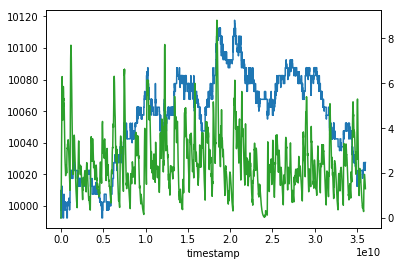

In [33]:
mid_prices.plot()
mean_prices.plot()
vols.plot(secondary_y=True)

In [34]:
volume_imb = df['bq0'] - df['aq0']

In [37]:
period = 1e8
smooth_imb = smooth_signals(volume_imb, period)

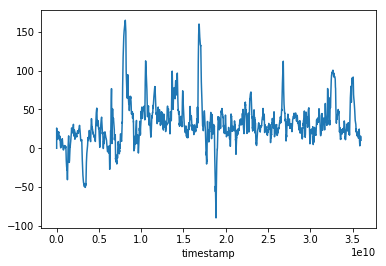

In [38]:
smooth_imb.plot()

In [33]:
df[['price', 'side', 'quantity', 'action', 'bp0', 'bq0', 'ap0', 'aq0','ofi']].head(20)

,price,side,quantity,action,bp0,bq0,ap0,aq0,ofi
timestamp,,,,,,,,,
0,9990,b,11,a,9990,11,NaN,NaN,11
0,9990,b,16,a,9990,27,NaN,NaN,16
0,9995,a,1,a,9990,27,9995.0,1.0,-1
0,9990,b,6,a,9990,33,9995.0,1.0,6
0,9990,b,1,a,9990,34,9995.0,1.0,1
0,9985,b,1,a,9990,34,9995.0,1.0,0
0,10000,a,1,a,9990,34,9995.0,1.0,0
0,9985,b,1,a,9990,34,9995.0,1.0,0
0,10000,a,1,a,9990,34,9995.0,1.0,-1


In [34]:
df['ofi'].describe()

count    138813.000000
mean         -0.026518
std           9.771522
min        -125.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         240.000000
Name: ofi, dtype: float64

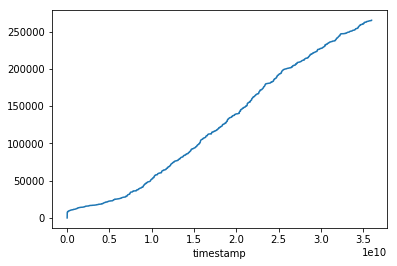

In [35]:
np.abs(df['ofi']).cumsum().plot()

In [36]:
df.index[:10]

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='int64', name='timestamp')

In [50]:
diff = df.index[1:] - df.index[:-1]

In [53]:
diff[diff > 0].values.mean()

154454.7318923279

In [54]:
from helper import Sum
from tqdm import tqdm_notebook

ofi_sum = Sum(1e6)
ofis = []
for i in tqdm_notebook(range(df.shape[0])):
    x = df.iloc[i]
    timestamp = df.index[i]
    ofi_sum.update(x['ofi'], timestamp)
    ofi = ofi_sum.get_signal()
    ofis.append(ofi)

HBox(children=(IntProgress(value=0, max=264467), HTML(value='')))

In [55]:
ofis = pd.Series(ofis, index=df.index)

In [56]:
ofis.describe()

count    264467.000000
mean         -1.153668
std          51.700187
min        -474.000000
25%         -12.000000
50%           0.000000
75%           8.000000
max         466.000000
dtype: float64

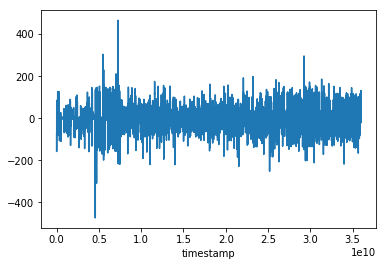

In [57]:
ofis.plot()

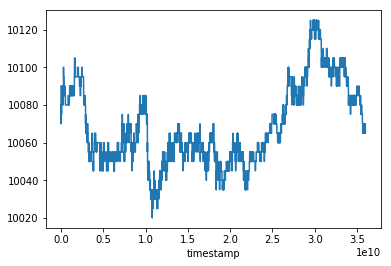

In [58]:
df['ap0'].plot()

In [42]:
dfs = []
for i in range(4):
    df = pd.read_csv(f'outputs/output_res_2019061{i}.csv', index_col='timestamp')
    dfs.append(df)

In [43]:
quantities = [df['quantity'].sum() for df in dfs]
quantities

[345951, 574523, 730994, 727386]

In [44]:
lengths = [(df.index[-1] - df.index[0]) * 1e-6 for df in dfs]
lengths

[36000.0, 36000.0, 36000.0, 36000.0]

In [45]:
ask_diffs = [df['ap0'].diff().fillna(0).unique() for df in dfs]
bid_diffs = [df['bp0'].diff().fillna(0).unique() for df in dfs]
print(ask_diffs)
print(bid_diffs)

[array([  0.,   5.,  -5., -10.,  10.]), array([  0.,  -5.,   5., -10.]), array([  0.,  -5.,   5., -10.]), array([  0., -15.,   5.,  -5., -10.,  10.])]
[array([ 0.,  5., -5., 10.]), array([ 0., -5.,  5.]), array([ 0., -5.,  5., 10.]), array([ 0., -5.,  5.])]


In [46]:
ask_diffs = [df['ap0'].diff().fillna(0) for df in dfs]
ask_diffs = [x[x != 0].shape[0] for x in ask_diffs]
ask_diffs = [lengths[i] / ask_diffs[i] for i in range(len(lengths))]
bid_diffs = [df['bp0'].diff().fillna(0) for df in dfs]
bid_diffs = [x[x != 0].shape[0] for x in bid_diffs]
bid_diffs = [lengths[i] / bid_diffs[i] for i in range(len(lengths))]
print(ask_diffs)
print(bid_diffs)

[27.54399387911247, 13.595166163141993, 11.225444340505145, 11.494252873563218]
[15.901060070671377, 13.688212927756654, 11.331444759206798, 10.650887573964496]


In [47]:
[df['aq0'].mean() for df in dfs]

[24.788532609087177, 48.15029024682058, 50.452229299363054, 47.21140255684074]

In [48]:
[df['bq0'].mean() for df in dfs]

[43.48558132163414, 51.89983914351677, 50.70632233653632, 48.823602367042895]

In [120]:
return_period = 1000
sample_qty = 100

In [58]:
diff = df['ap0'].diff()

In [62]:
df['ap4'].max()

10145.0

In [54]:
df['ap0'].max()

10125

In [55]:
spread = df['ap0'] - df['bp0']

In [56]:
spread.describe()

count    264465.000000
mean          5.335111
std           1.252494
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          20.000000
dtype: float64

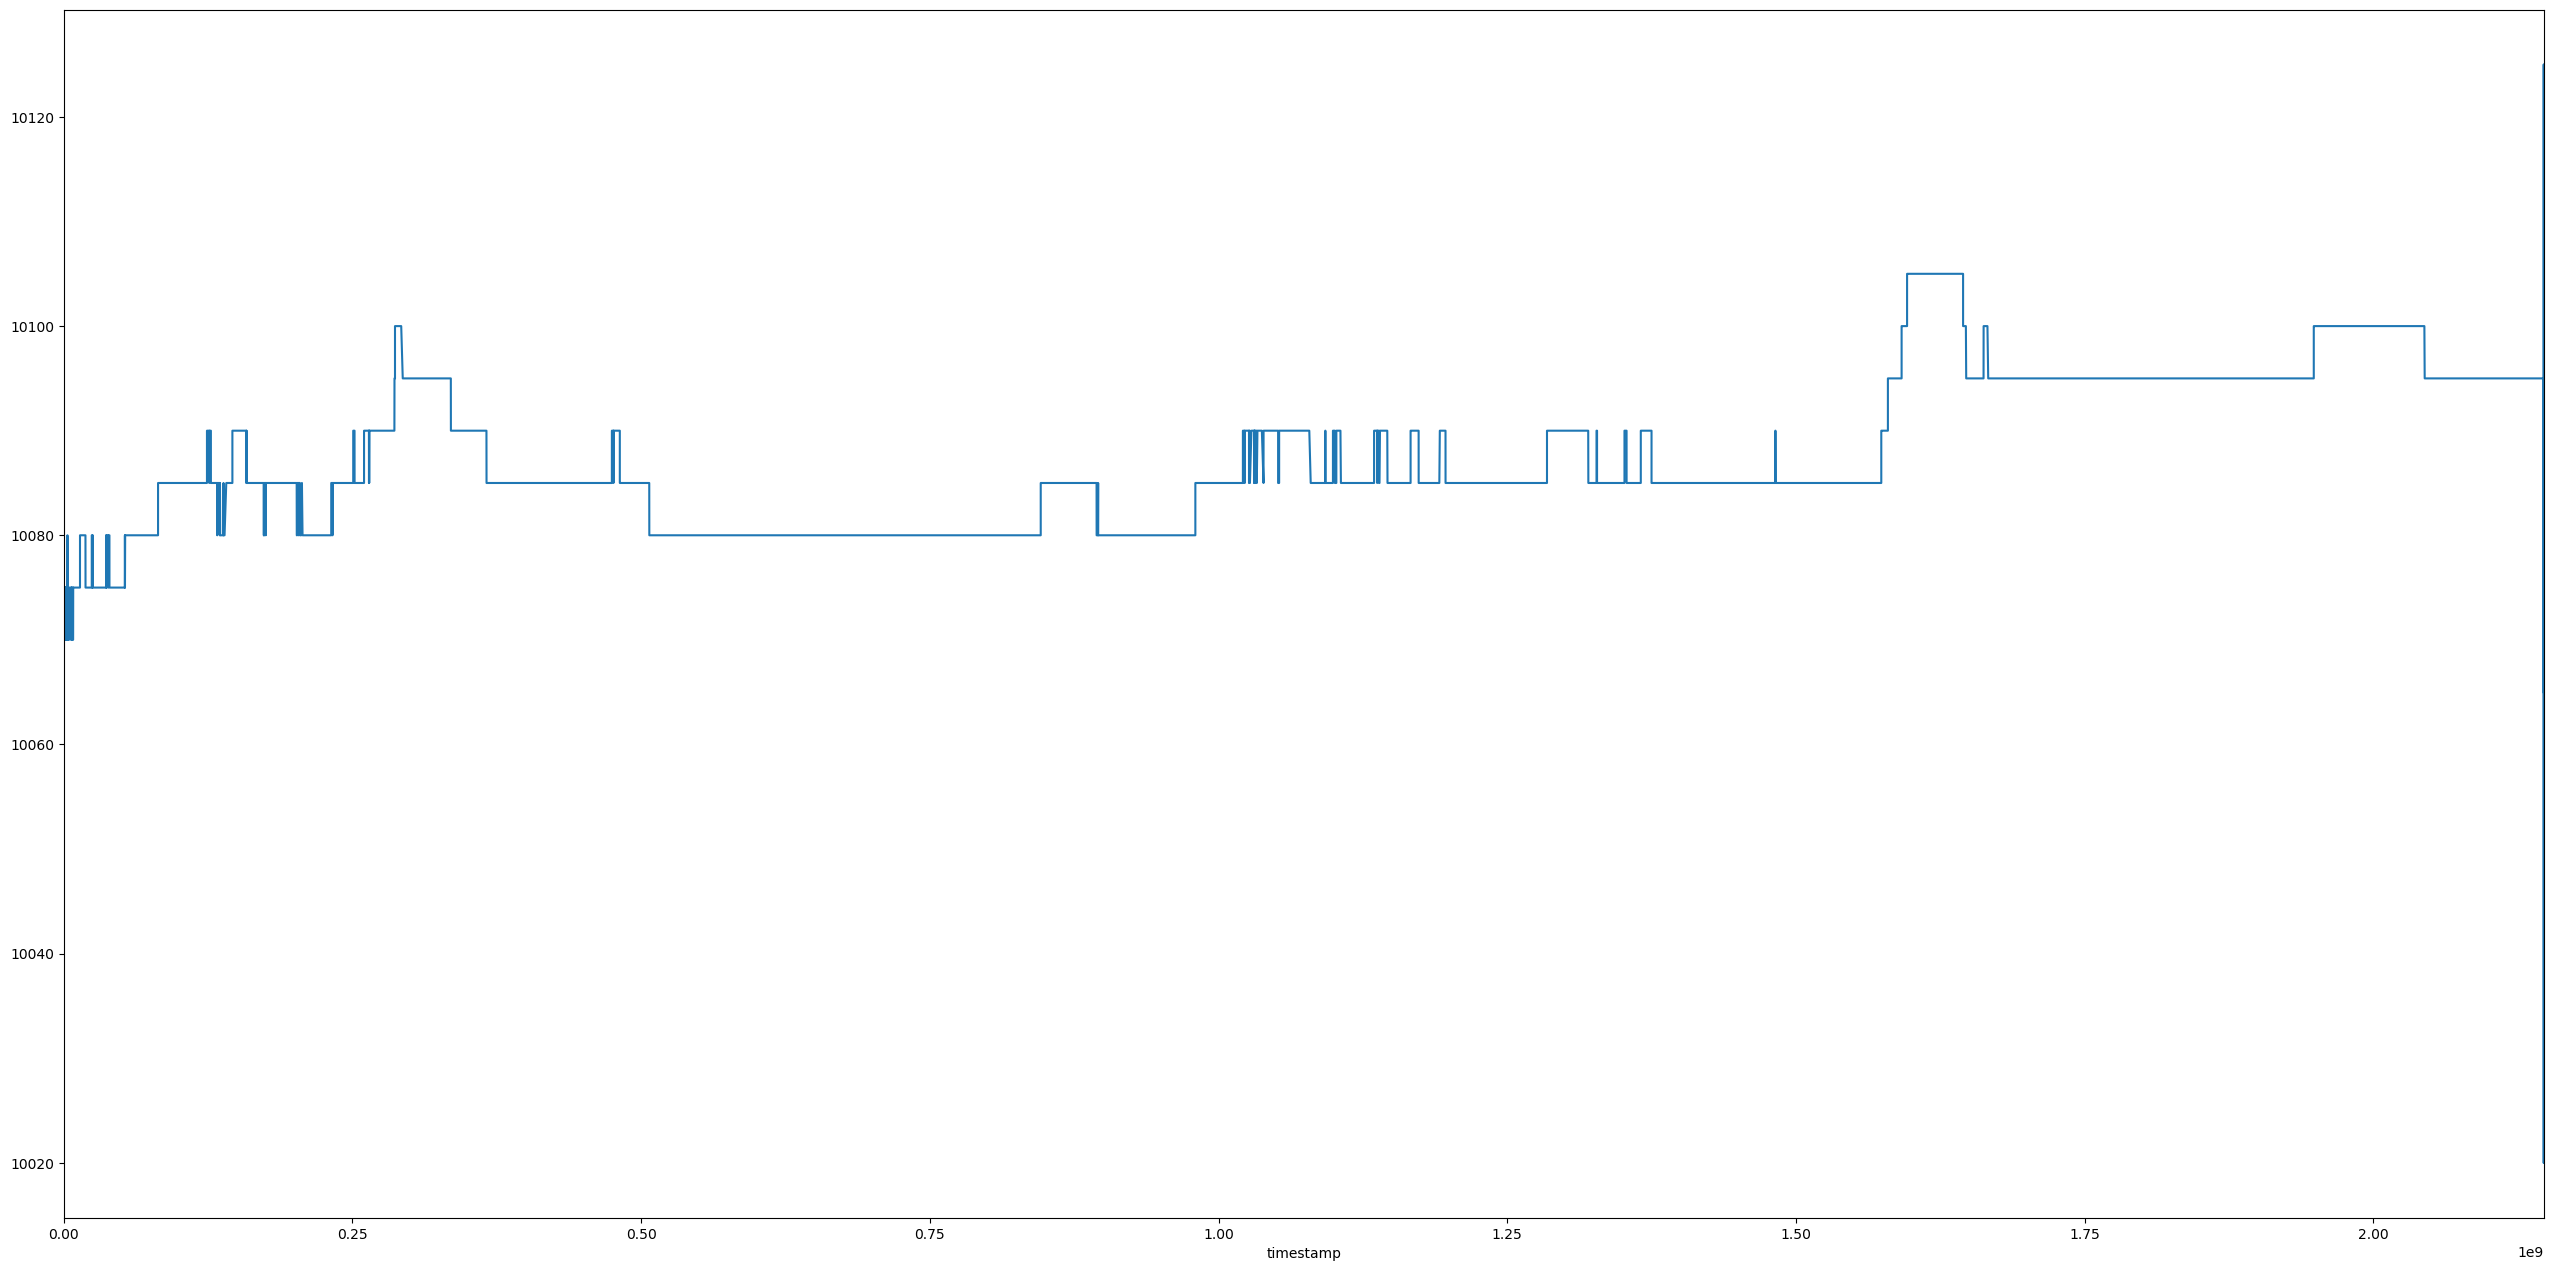

In [57]:
%matplotlib inline
df['ap0'].plot()

In [92]:
dfs[0]

,price,side,quantity,action,bp0,bq0,bp1,bq1,bp2,bq2,...,ap0,aq0,ap1,aq1,ap2,aq2,ap3,aq3,ap4,aq4
timestamp,,,,,,,,,,,,,,,,,,,,,
0,9990,b,11,a,9990,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,9990,b,16,a,9990,27,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,9995,a,1,a,9990,27,NaN,NaN,NaN,NaN,...,9995.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,9990,b,6,a,9990,33,NaN,NaN,NaN,NaN,...,9995.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,9990,b,1,a,9990,34,NaN,NaN,NaN,NaN,...,9995.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147483647,10025,b,1,d,10025,14,10020.0,74.0,10015.0,75.0,...,10030.0,16.0,10035.0,103.0,10040.0,91.0,10045.0,59.0,10050.0,13.0
2147483647,10025,b,1,d,10025,13,10020.0,74.0,10015.0,75.0,...,10030.0,16.0,10035.0,103.0,10040.0,91.0,10045.0,59.0,10050.0,13.0
2147483647,10050,a,1,a,10025,13,10020.0,74.0,10015.0,75.0,...,10030.0,16.0,10035.0,103.0,10040.0,91.0,10045.0,59.0,10050.0,14.0


In [31]:
df['ap0'].iloc[-1000:]

timestamp
2147483647    10065
2147483647    10065
2147483647    10065
2147483647    10065
2147483647    10065
              ...  
2147483647    10065
2147483647    10065
2147483647    10065
2147483647    10065
2147483647    10065
Name: ap0, Length: 1000, dtype: int64

In [19]:
x = df['ap0']

In [20]:
(df.index[-1] - df.index[0]) * 1e-6

2147.483647

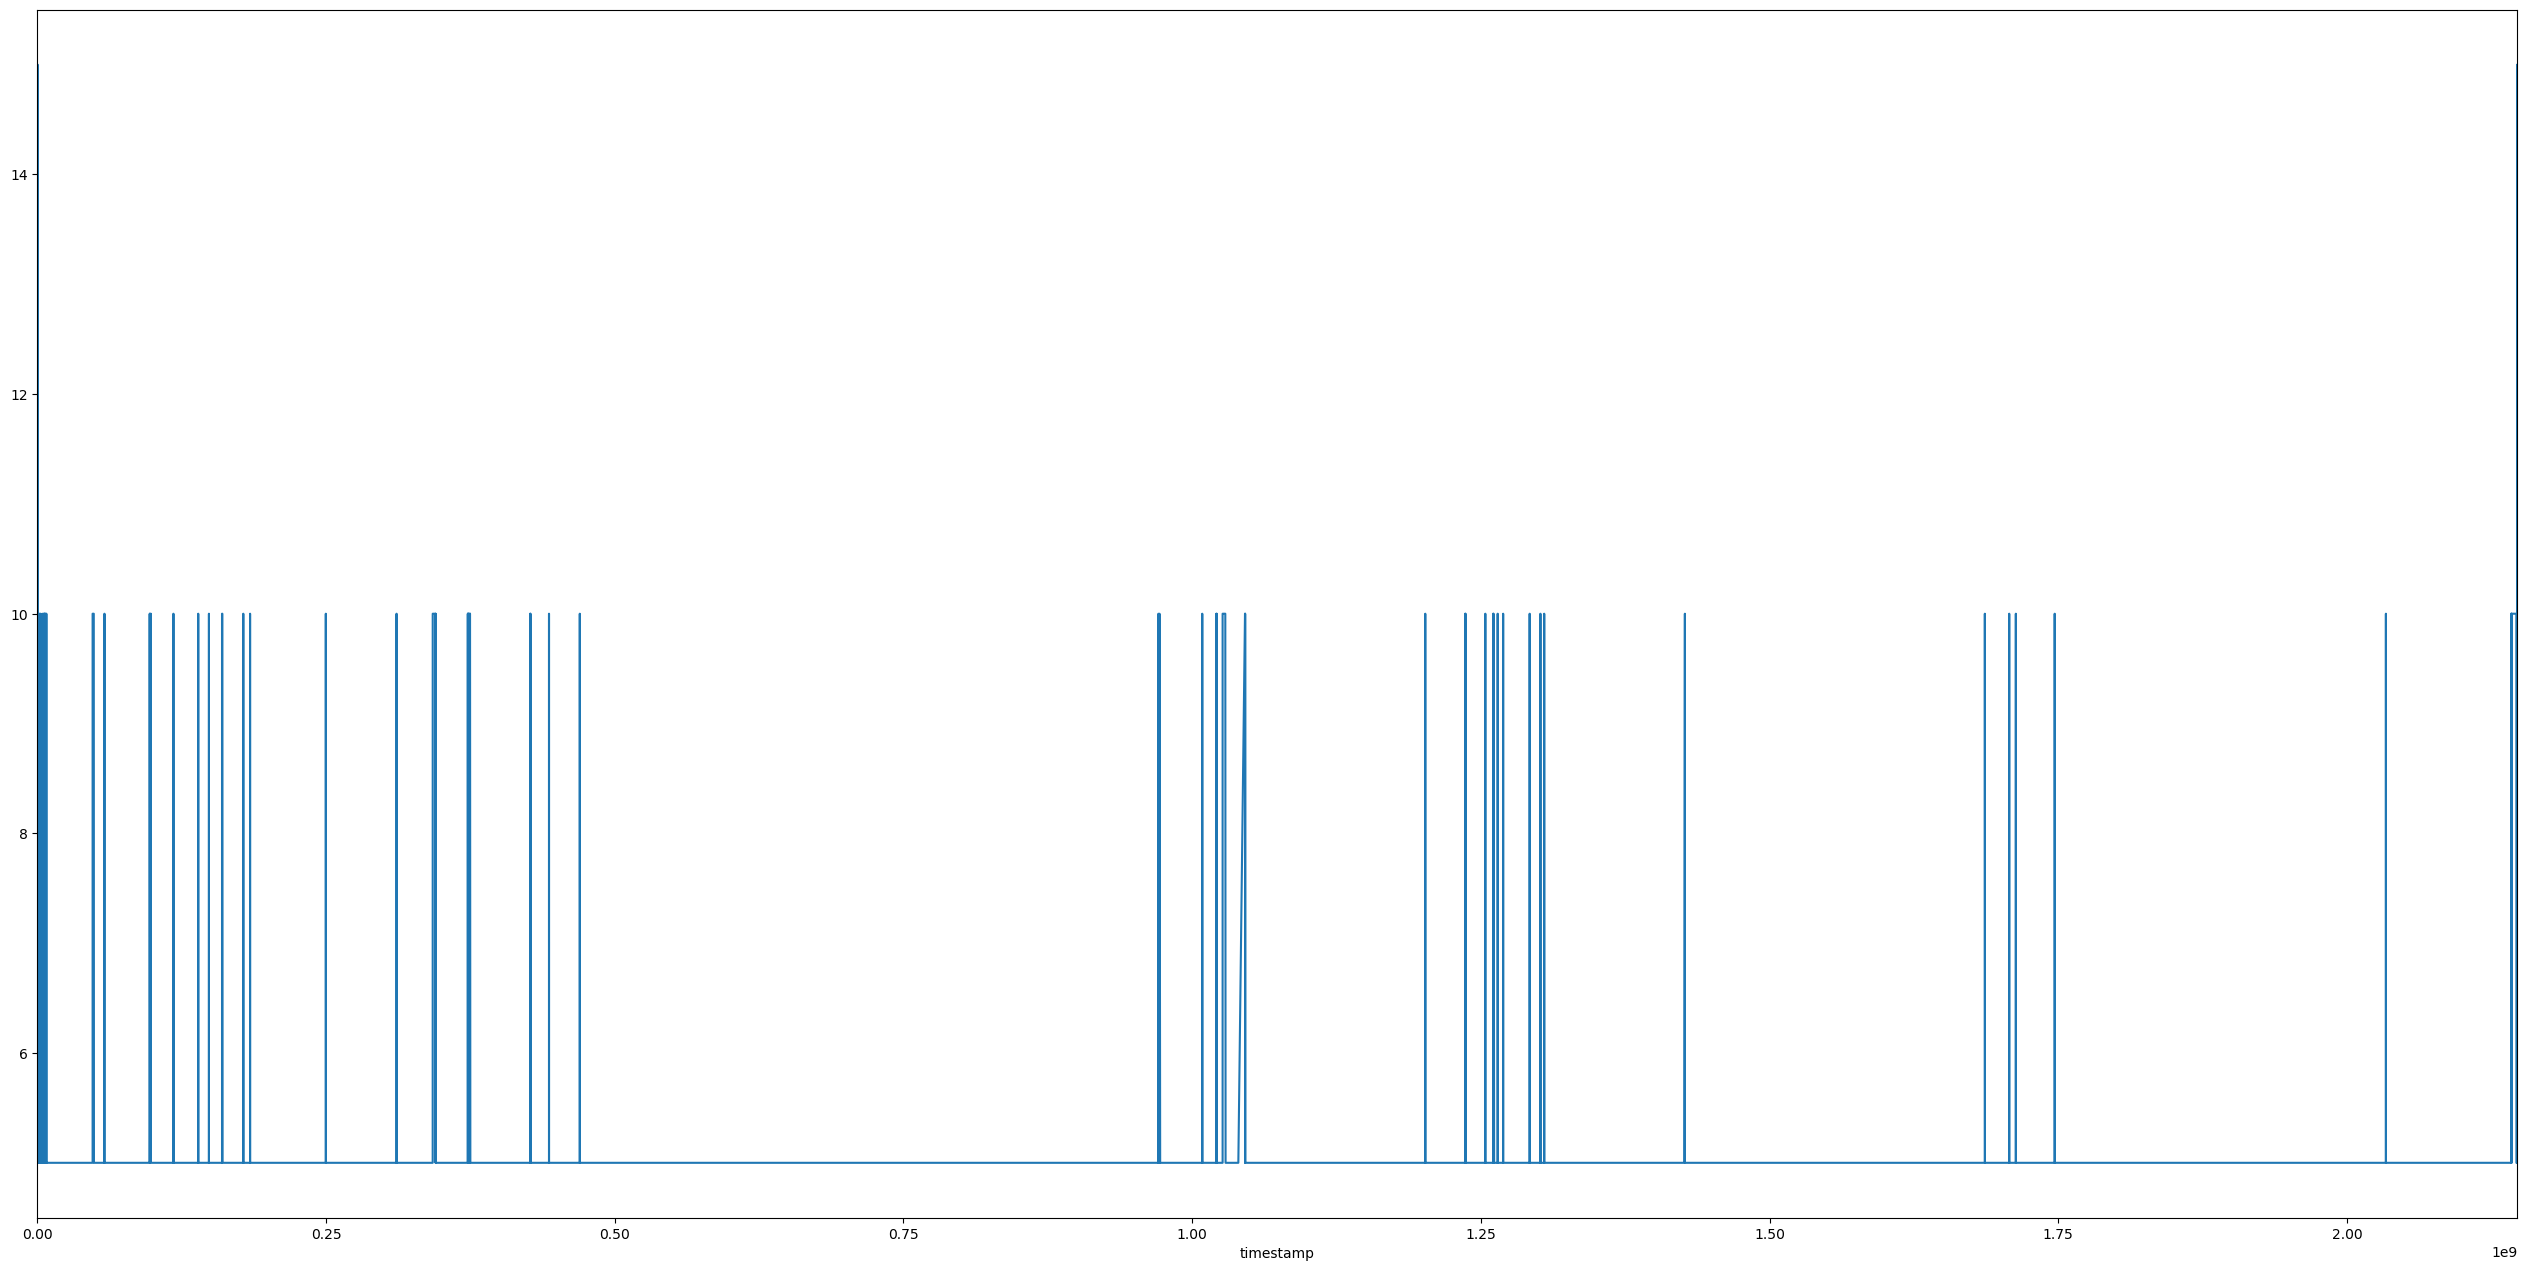

In [8]:
spread.plot()